<a href="https://colab.research.google.com/github/Carol-Kelly/Hamoye_Internship/blob/main/StageC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Electrical Grid Stability Simulated Dataset**

#### **Problem Statement**
To predict the balance (stable or unstable) between electricity supply and demand in electrical grids.

#### **Data Source**
This data was downloaded from the UCI library via the link: https://archive.ics.uci.edu/ml/datasets/Electrical+Grid+Stability+Simulated+Data

#### **Data Collection**

In [1]:
import io
from google.colab import files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score 

In [2]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['Data_for_UCI_named.csv']))

Saving Data_for_UCI_named.csv to Data_for_UCI_named (1).csv


In [3]:
print(f'Dimension of dataset: {df.shape}')
df.head()

Dimension of dataset: (10000, 14)


tau1      tau2      tau3      tau4        p1        p2        p3  \
0  2.959060  3.079885  8.381025  9.780754  3.763085 -0.782604 -1.257395   
1  9.304097  4.902524  3.047541  1.369357  5.067812 -1.940058 -1.872742   
2  8.971707  8.848428  3.046479  1.214518  3.405158 -1.207456 -1.277210   
3  0.716415  7.669600  4.486641  2.340563  3.963791 -1.027473 -1.938944   
4  3.134112  7.608772  4.943759  9.857573  3.525811 -1.125531 -1.845975   

         p4        g1        g2        g3        g4      stab     stabf  
0 -1.723086  0.650456  0.859578  0.887445  0.958034  0.055347  unstable  
1 -1.255012  0.413441  0.862414  0.562139  0.781760 -0.005957    stable  
2 -0.920492  0.163041  0.766689  0.839444  0.109853  0.003471  unstable  
3 -0.997374  0.446209  0.976744  0.929381  0.362718  0.028871  unstable  
4 -0.554305  0.797110  0.455450  0.656947  0.820923  0.049860  unstable

In [4]:
# shuffle dataframe to reduce variance in the dataset
df = shuffle(df).reset_index(drop=True)

#### **Data Cleaning**

In [5]:
# check for missing values
df.isna().sum()

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64

In [6]:
# check for duplicate values
df.duplicated().any()

False

In [7]:
# drop one of the target variables due to correlation
df.drop('stab', axis=1, inplace=True)

#### **Exploratory Data Analysis**

In [8]:
# check for distribution of target variable
df.stabf.value_counts()

unstable    6380
stable      3620
Name: stabf, dtype: int64

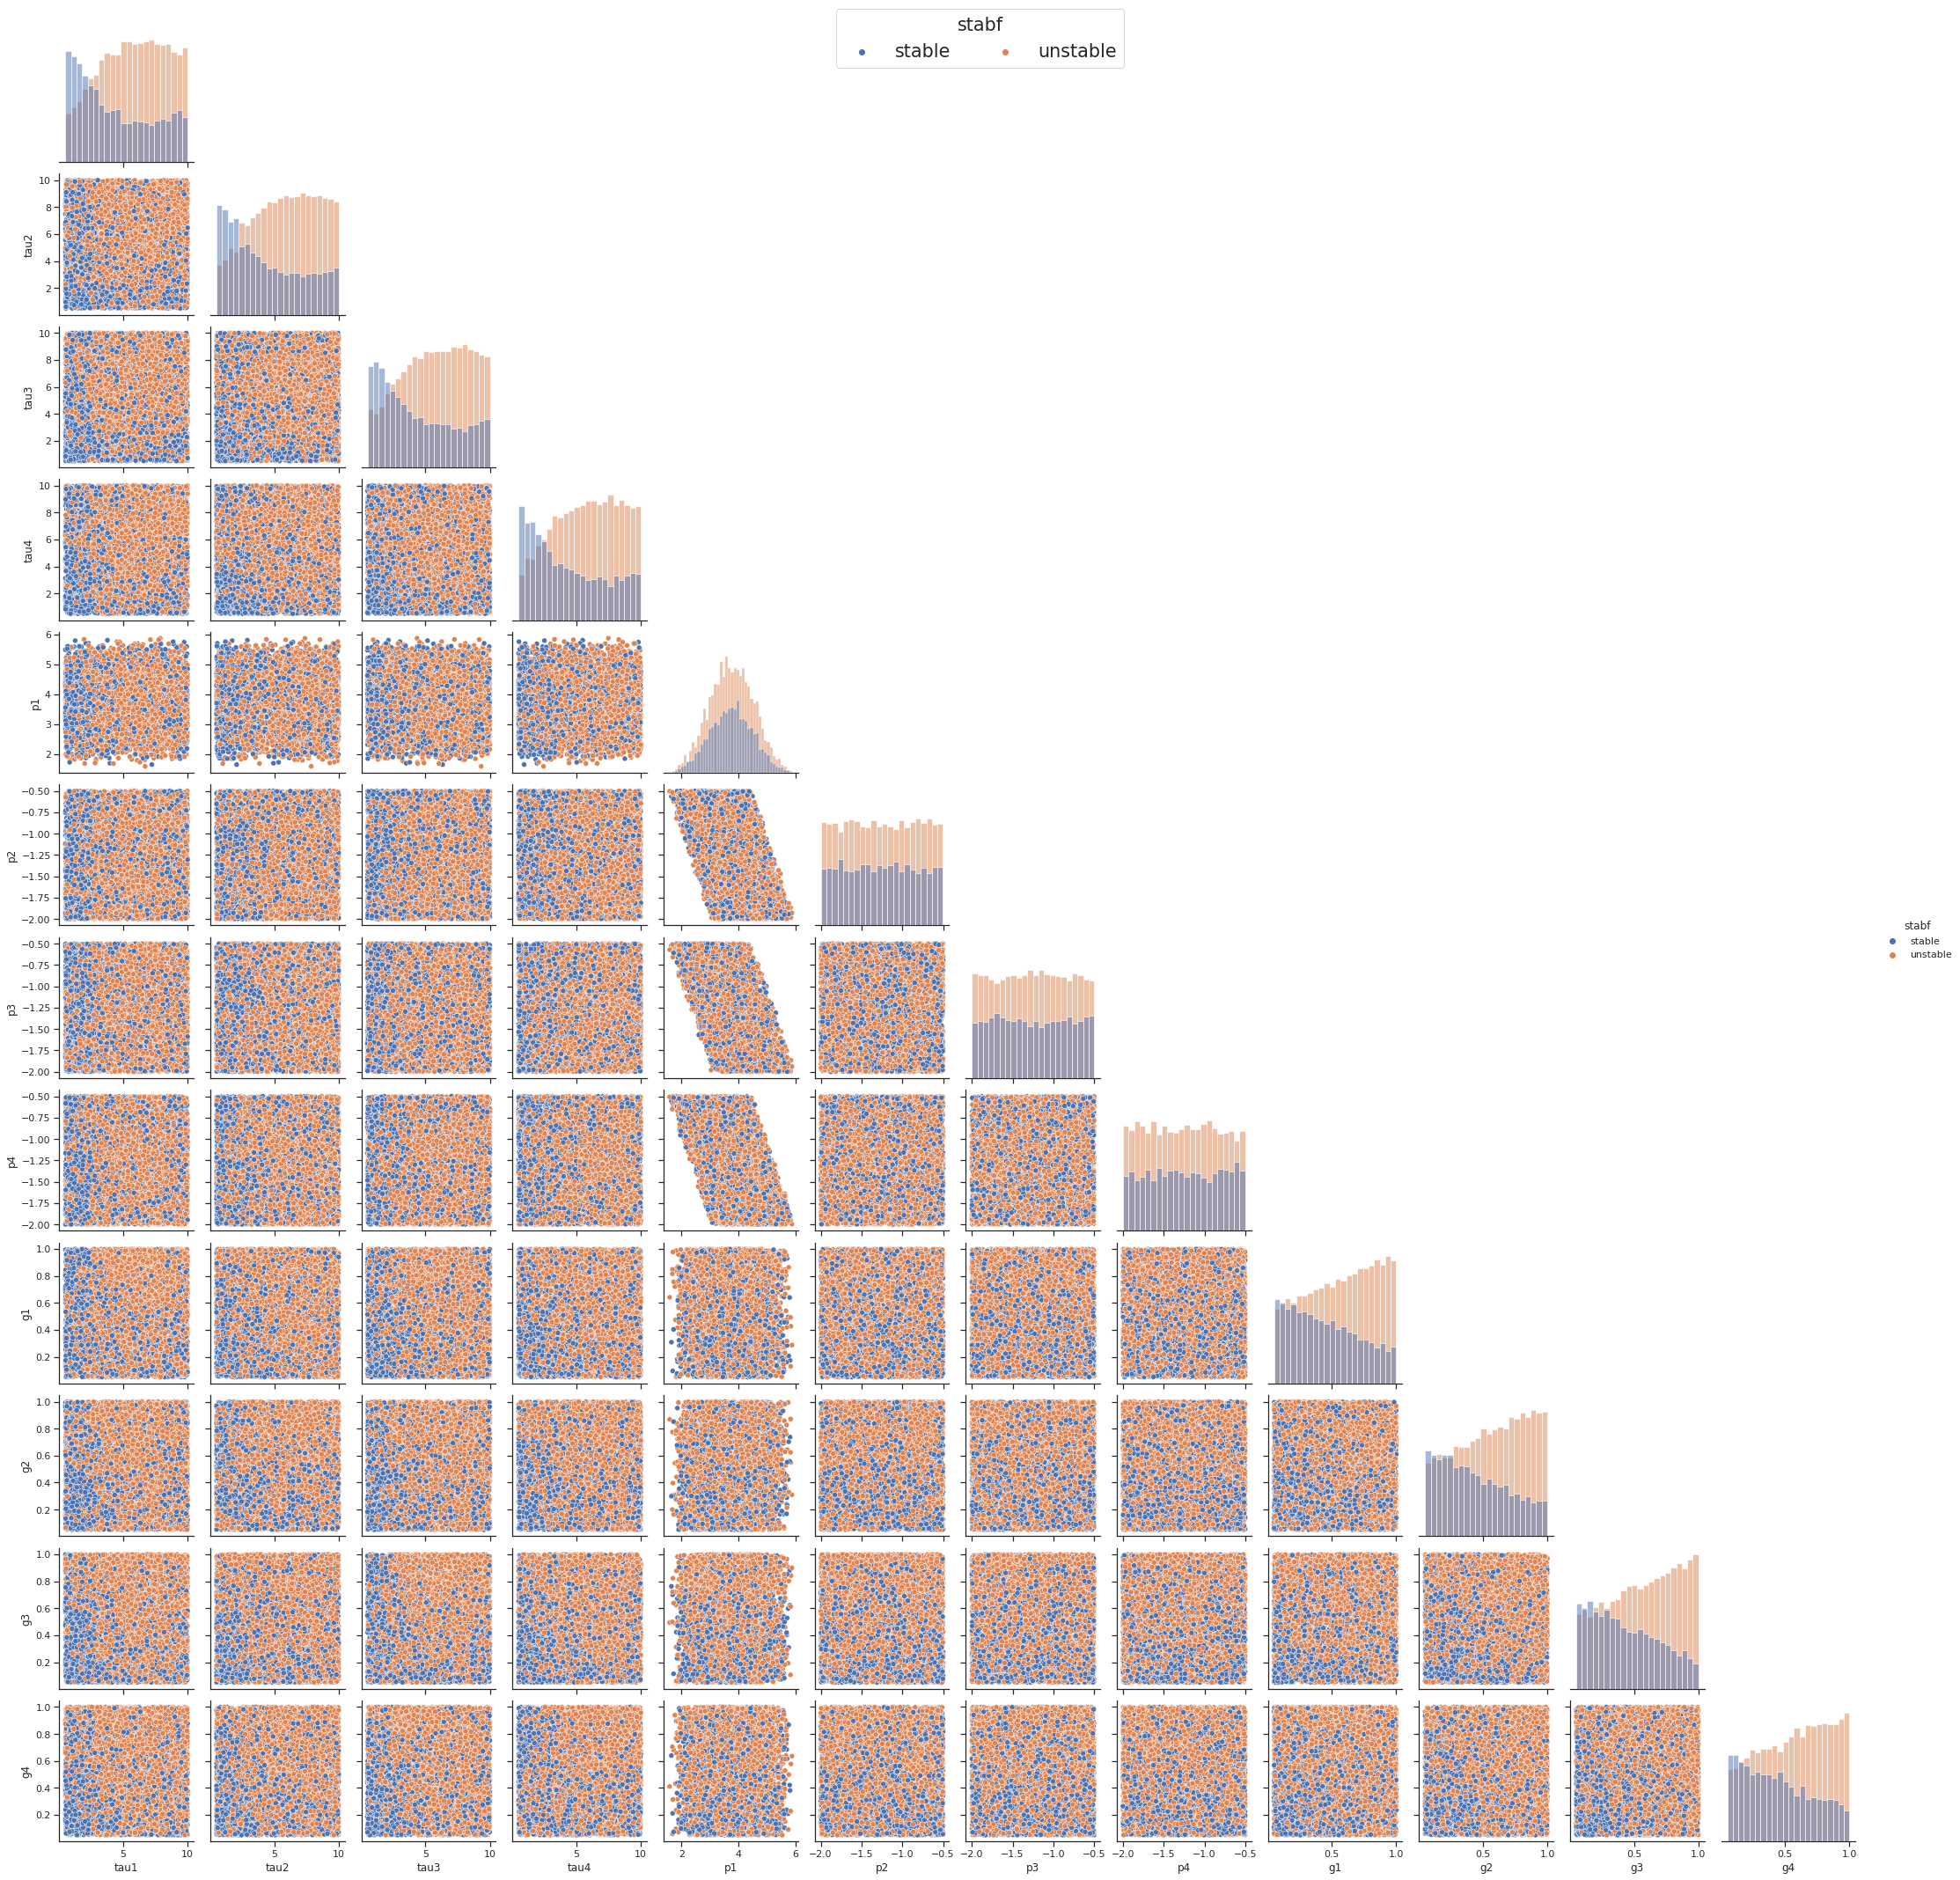

In [9]:
# Data visualization
sns.set(style="ticks")
g = sns.pairplot(df, hue='stabf', corner = True, diag_kind='hist')
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=2, title='stabf', fontsize='xx-large', title_fontsize='xx-large')
plt.show()

From the visualizations, p1 is the only variable with normal distribution; p2, p3 and p4 have uniform ditribution. p2, p3, p4 are negatively correlated with p1 as can also be seen in the heat map below. tau1-tau4, g1-g4 are skewed causing an imbalance in the dataset.  

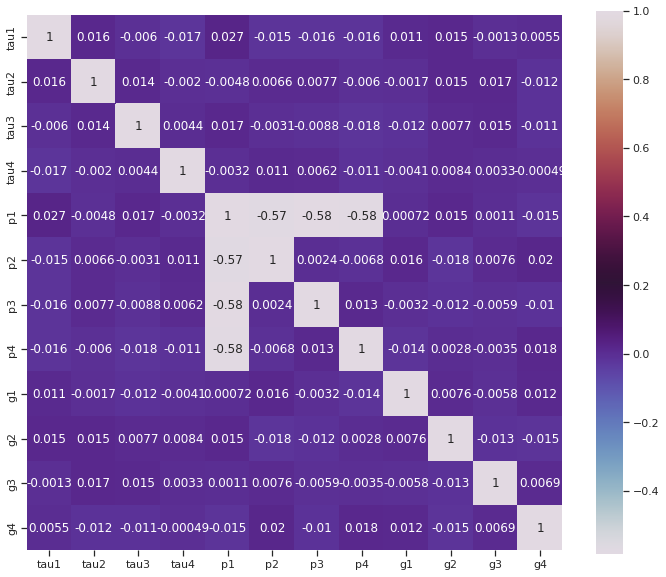

In [10]:
#Plotting a correlation matrix
plt.figure(figsize = (12,10))
corr_map = df.corr()
sns.heatmap(corr_map, annot = True, cmap = 'twilight', square=True)

#### **Feature Engineering**

In [11]:
# descriptive statistics of the dataset
df.describe(include='all')

tau1          tau2          tau3          tau4            p1  \
count   10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean        5.250000      5.250001      5.250004      5.249997      3.750000   
std         2.742548      2.742549      2.742549      2.742556      0.752160   
min         0.500793      0.500141      0.500788      0.500473      1.582590   
25%         2.874892      2.875140      2.875522      2.874950      3.218300   
50%         5.250004      5.249981      5.249979      5.249734      3.751025   
75%         7.624690      7.624893      7.624948      7.624838      4.282420   
max         9.999469      9.999837      9.999450      9.999443      5.864418   

                  p2            p3            p4            g1            g2  \
count   10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean       -1.250000     -1.250000     -1.250000      0.525000      0.525000   
std         0.433035      0.433035      0.433035      0.274256      0.274255   
min        -1.999891     -1.999945     -1.999926      0.050009      0.050053   
25%        -1.624901     -1.625025     -1.624960      0.287521      0.287552   
50%        -1.249966     -1.249974     -1.250007      0.525009      0.525003   
75%        -0.874977     -0.875043     -0.875065      0.762435      0.762490   
max        -0.500108     -0.500072     -0.500025      0.999937      0.999944   

                  g3            g4     stabf  
count   10000.000000  10000.000000     10000  
unique           NaN           NaN         2  
top              NaN           NaN  unstable  
freq             NaN           NaN      6380  
mean        0.525000      0.525000       NaN  
std         0.274255      0.274255       NaN  
min         0.050054      0.050028       NaN  
25%         0.287514      0.287494       NaN  
50%         0.525015      0.525002       NaN  
75%         0.762440      0.762433       NaN  
max         0.999982      0.999930       NaN

In [12]:
# split the dataset into train and test split
X = df.drop(columns = 'stabf')
y = df['stabf']
x_train,x_test,y_train,y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=1)

In [13]:
# check the distribution of the train target variable
y_train.value_counts()

unstable    5086
stable      2914
Name: stabf, dtype: int64

In [14]:
# encoding the categorical feature 
encode = LabelEncoder()
y_train = encode.fit_transform(y_train)
y_test = encode.fit_transform(y_test)

In [15]:
# balance the dataset
counter = Counter(y_train)
print(f'Before Balancing: {counter}')
smt = SMOTE(random_state=1)
x_train_balance, y_train_balance = smt.fit_resample(x_train, y_train)
counter = Counter(y_train_balance)
print(f'After Balancing: {counter}')

Before Balancing: Counter({1: 5086, 0: 2914})
After Balancing: Counter({1: 5086, 0: 5086})


In [16]:
# feature scaling
scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train_balance)
x_train_std_df = pd.DataFrame(x_train_std, columns=x_train.columns)

x_test = x_test.reset_index(drop=True)
x_test_std = scaler.fit_transform(x_test)
x_test_std_df = pd.DataFrame(x_test_std, columns=x_test.columns)

#### **Model Building**

In [17]:
rfc = RandomForestClassifier(random_state=1)
rfc.fit(x_train_std_df, y_train_balance)
rfc_pred = rfc.predict(x_test_std_df)
rfc_pred

array([1, 1, 1, ..., 1, 1, 1])

In [18]:
extratrees = ExtraTreesClassifier(random_state=1)
extratrees.fit(x_train_std_df, y_train_balance)
extratrees_pred = extratrees.predict(x_test_std_df)
extratrees_pred

array([1, 1, 0, ..., 1, 1, 1])

In [19]:
xgbc = XGBClassifier(random_state=1)
xgbc.fit(x_train_std_df, y_train_balance)
xgbc_pred = xgbc.predict(x_test_std_df)
xgbc_pred

array([1, 1, 0, ..., 1, 1, 0])

In [20]:
lgbmc = LGBMClassifier(random_state=1)
lgbmc.fit(x_train_std_df, y_train_balance)
lgbmc_pred = lgbmc.predict(x_test_std_df)
lgbmc_pred

array([1, 1, 0, ..., 1, 1, 0])

##### **Model Metrics**


*   What is the accuracy on the test set using the LGBM classifier? In 4 decimal places
*   What is the accuracy on the test set using the XGboost classifier? In 4 decimal places.
*   What is the accuracy on the test set using the random forest classifier? In 4 decimal places





In [21]:
accuracy = accuracy_score(y_test, lgbmc_pred)
print('Accuracy: {}'.format(round(accuracy, 4)))

Accuracy: 0.9095


In [22]:
accuracy = accuracy_score(y_test, xgbc_pred)
print('Accuracy: {}'.format(round(accuracy, 4)))

Accuracy: 0.8995


In [23]:
accuracy = accuracy_score(y_test, rfc_pred)
print('Accuracy: {}'.format(round(accuracy, 4)))

Accuracy: 0.899


#### **Model Tuning**

Using the ExtraTreesClassifier as your estimator with cv=5, n_iter=10, scoring = 'accuracy', n_jobs = -1, verbose = 1 and random_state = 1. What are the best hyperparameters from the randomized search CV?

In [24]:
parameters = {
 'n_estimators' : [100, 300, 500, 1000],
 'max_features': ['auto', 'sqrt', 'log2' , None],
 'min_samples_split' : [2, 5, 7],
 'min_samples_leaf' : [4, 6, 8]
}
rand_xtrees = RandomizedSearchCV(extratrees, parameters, cv=5, n_iter=10, scoring='accuracy', verbose=1, n_jobs=-1, random_state=1)
rand_xtrees

RandomizedSearchCV(cv=5, estimator=ExtraTreesClassifier(random_state=1),
                   n_jobs=-1,
                   param_distributions={'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [4, 6, 8],
                                        'min_samples_split': [2, 5, 7],
                                        'n_estimators': [100, 300, 500, 1000]},
                   random_state=1, scoring='accuracy', verbose=1)

Train a new ExtraTreesClassifier Model with the new Hyperparameters from the RandomizedSearchCV (with random_state = 1). Is the accuracy of the new optimal model higher or lower than the initial ExtraTreesClassifier model with no hyperparameter tuning?

In [25]:
rand_xtrees.fit(x_train_std_df, y_train_balance)
rand_xtrees_pred = rand_xtrees.predict(x_test_std_df)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [26]:
# accuracy of initial model
accuracy = accuracy_score(y_test, extratrees_pred)
print('Accuracy: {}'.format(round(accuracy, 4)))

Accuracy: 0.9025


In [27]:
# accuracy of optimal model
rand_xtrees_accuracy = accuracy_score(y_test, rand_xtrees_pred)
print('Accuracy: {}'.format(round(accuracy, 4))) 

Accuracy: 0.9025


There is no change in accuracy.

#### **Feature Selection**

Find the feature importance using the optimal ExtraTreesClassifier model. Which features are the most and least important respectively?

Fitting 5 folds for each of 10 candidates, totalling 50 fits


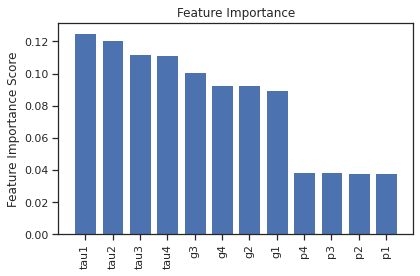

In [28]:
rand_xtrees.fit(x_train_std_df, y_train_balance.ravel())
feat_impt = extratrees.feature_importances_
# Sort the feature importance in descending order
sorted_indices = np.argsort(feat_impt)[::-1]

# plot the feature importance to obtain the most and least important respectively
plt.title('Feature Importance')
plt.bar(range(x_train_balance.shape[1]), feat_impt[sorted_indices], align='center')
plt.xticks(range(x_train_balance.shape[1]), x_train.columns[sorted_indices], rotation=90)
plt.ylabel('Feature Importance Score')
plt.tight_layout()
plt.show()

Therefore according to the options available, the  most and least important features respectively are: tau2 and p1